In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
bajaj=yf.download('BAJFINANCE.NS',start='2020-01-01',end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed

In [26]:
bajaj.to_csv('bajaj.csv')
bajaj=pd.read_csv('bajaj.csv')

#
MACD INDICATOR

In [27]:
def MACD(data):
    data['MACD']=data['Close'].ewm(span=12,adjust=False).mean()-data['Close'].ewm(span=26,adjust=False).mean()
    data['Signal']=data['MACD'].ewm(span=9,adjust=False).mean()
    return data

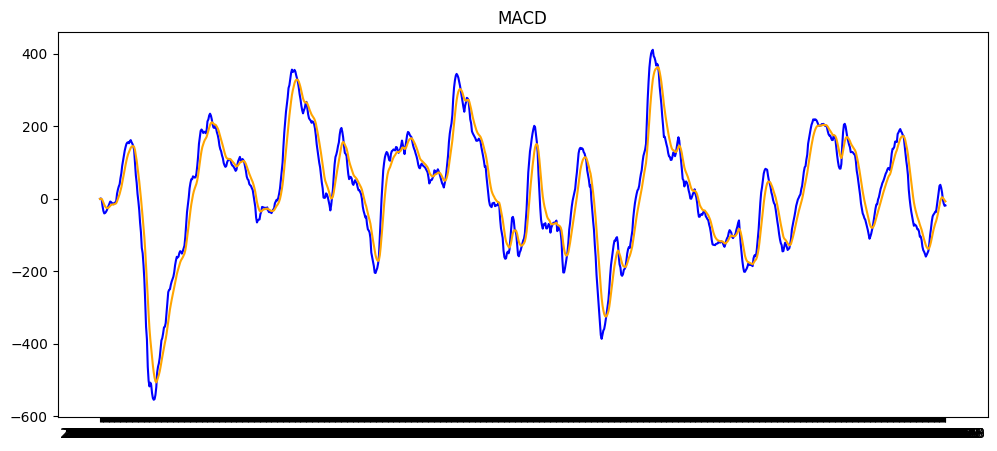

In [28]:
macd=MACD(bajaj)
# plt.plot(macd['Date'],macd['MACD'],label='MACD',color='blue')
# plt.plot(macd['Date'],macd['Signal'],label='Signal',color='orange')
# plt.title('MACD INDICATOR')
# plt.show()
plt.figure(figsize=(12, 5))
plt.plot(macd['Date'],macd['MACD'],label='MACD',color='b')
plt.plot(macd['Date'],macd['Signal'],label='Signal',color='orange')
plt.title('MACD')
plt.show()


#
RSI INDICATOR

In [29]:
def RSI(data,days=14):
    data['delta']=data['Close'].diff(1)
    data['positive']=data['delta']
    data['negative']=data['delta']
    for i in range(len(data['delta'])):
        if data['positive'].iloc[i]<0:
            data['positive'].iloc[i]=0
        elif data['negative'].iloc[i]>0:
            data['negative'].iloc[i]=0
    data['negative']=data['negative'].abs()          
    data['average_gain']=data['positive'].rolling(window=days).mean()
    data['average_loss']=data['negative'].rolling(window=days).mean()
    data['RI']=data['average_gain']/data['average_loss']
    data['RSI']=100 -(100/(1+data['RI']))
    return data

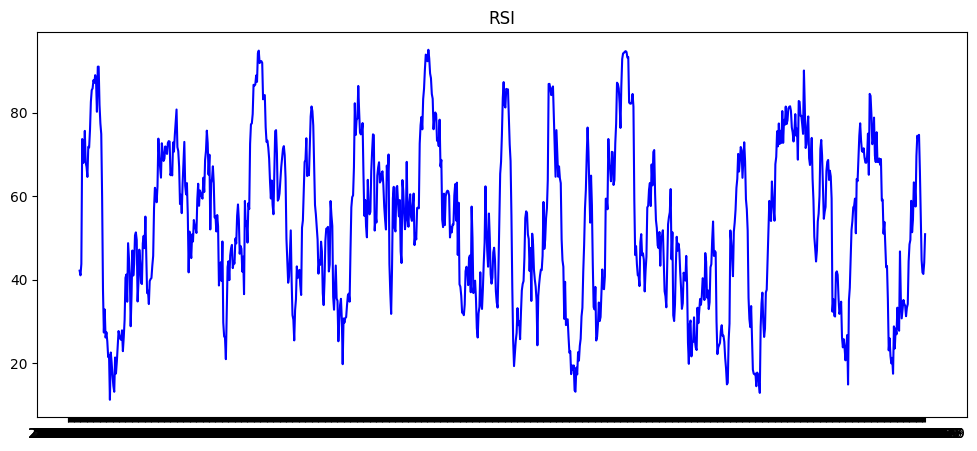

In [30]:
rsi=RSI(bajaj)
plt.figure(figsize=(12, 5))
plt.plot(rsi['Date'],rsi['RSI'],label='RSI',color='b')
plt.title('RSI')
plt.show()


#
BOLLINGER BAND

In [31]:
def BollingerBand(data,window=20,standard_dev=2):
    data['sma']=data['Close'].rolling(window=window).mean()
    data['sd']=data['Close'].rolling(window=window).std()
    data['Lower_Band']=data['sma']-standard_dev*data['sd']
    data['Upper_Band']=data['sma']+standard_dev*data['sd']
    data.drop('sd',axis=1,inplace=True)
    return data


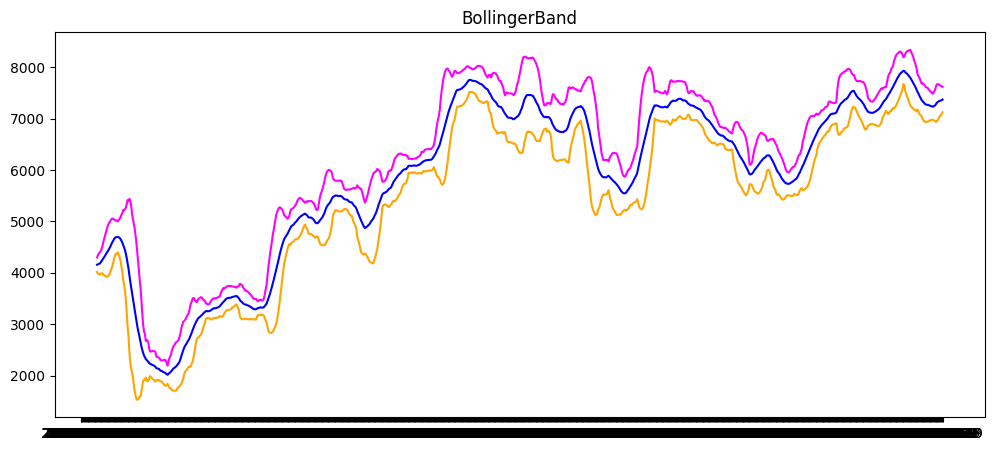

In [32]:
bollinger=BollingerBand(bajaj)
plt.figure(figsize=(12, 5))
plt.plot(bollinger['Date'],bollinger['sma'],label='sma',color='b')
plt.plot(bollinger['Date'],bollinger['Lower_Band'],label='Lower_Band',color='orange')
plt.plot(bollinger['Date'],bollinger['Upper_Band'],label='Upper_Band',color='magenta')
plt.title('BollingerBand')
plt.show()

#
MONEY FLOW INDEX 

In [33]:
def MFI(data,window=14):
    data['typical']=(data['High']+data['Low']+data['Close'])/3
    pmf=[0]
    nmf=[0]
    for i in range(1,len(data)):
        if data['typical'].iloc[i]>data['typical'].iloc[i-1]:
            pmf.append((data['typical'].iloc[i])*(data['Volume'].iloc[i]))
            nmf.append(0)
        elif data['typical'].iloc[i]<data['typical'].iloc[i-1]:
            nmf.append((data['typical'].iloc[i])*(data['Volume'].iloc[i]))
            pmf.append(0)
        else:
            nmf.append(0)
            pmf.append(0)    
    data['PMF']=pd.DataFrame(pmf)        
    data['NMF']=pd.DataFrame(nmf)
    data['PMF14']=data['PMF'].rolling(window=window).sum()
    data['NMF14']=data['NMF'].rolling(window=window).sum()
    data['MFR']=data['PMF14']/data['NMF14']
    data['MFI']=(100-(100/(1+data['MFR'])))
    data.drop('PMF',axis=1,inplace=True)
    data.drop('NMF',axis=1,inplace=True)
    data.drop('PMF14',axis=1,inplace=True)
    data.drop('NMF14',axis=1,inplace=True)
    data.drop('MFR',axis=1,inplace=True)
    return data



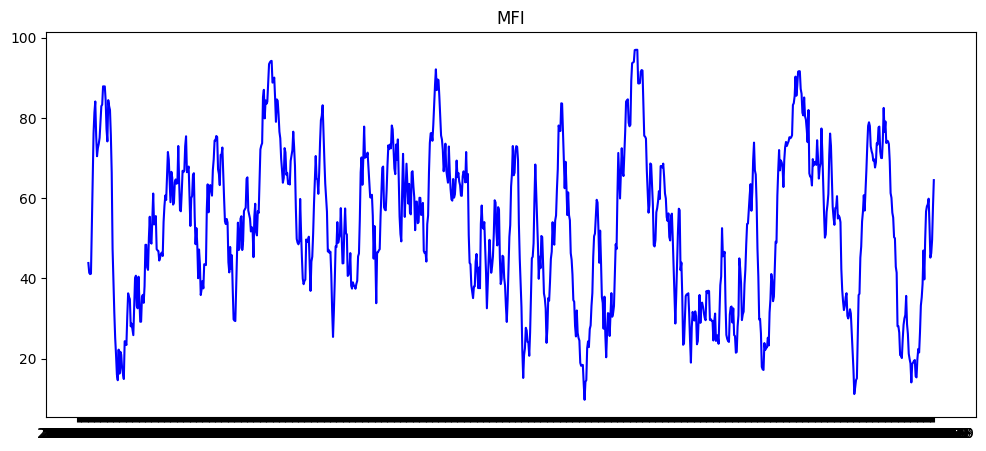

In [34]:
mfi=MFI(bajaj)
plt.figure(figsize=(12, 5))
plt.plot(mfi['Date'],mfi['MFI'],label='MFI',color='b')
plt.title('MFI')
plt.show()

#
ATR CALCULATOR

In [35]:
def ATR(data,n):
    df=data.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-Cp']=abs((df['High']-df['Close']).shift(1))
    df['L-Cp']=abs((df['Low']-df['Close']).shift(1))
    df['TR']=df[['H-L','H-Cp','L-Cp']].max(axis=1)
    df['ATR']=df['TR'].ewm(span=n,adjust=False).mean()
    df=df.drop(['H-L','H-Cp','L-Cp'],axis=1)
    return df

#
KELTNER CHANNEL

In [36]:
def KeltnerChannel(data,window=20,multiplier=2):
    data['middle']=data['Close'].ewm(span=window,adjust=False).mean()
    data=ATR(data,window)
    data['upper']=data['middle']+multiplier*data['ATR']
    data['lower']=data['middle']-multiplier*data['ATR']
    return data




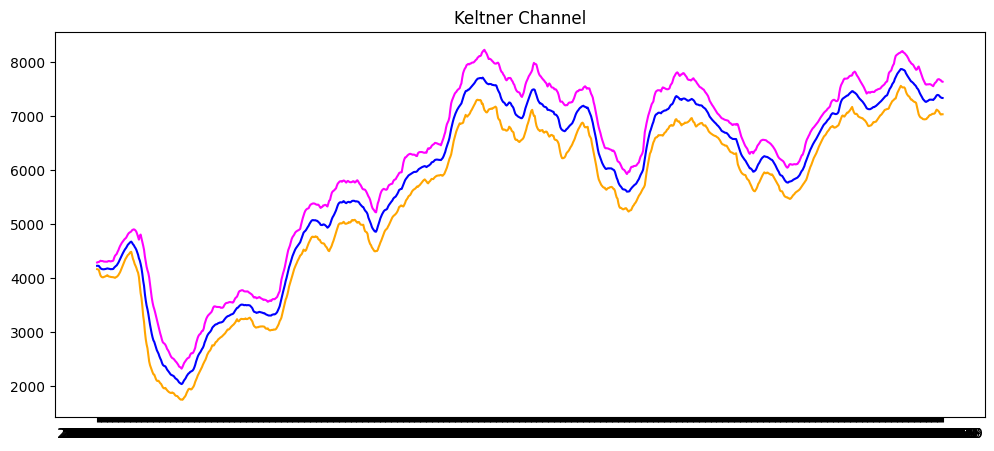

In [37]:
kc=KeltnerChannel(bajaj)
plt.figure(figsize=(12, 5))
plt.plot(kc['Date'],kc['middle'],label='middle',color='b')
plt.plot(kc['Date'],kc['lower'],label='Lower_Band',color='orange')
plt.plot(kc['Date'],kc['upper'],label='Upper_Band',color='magenta')
plt.title('Keltner Channel')
plt.show()

#
SUPERTREND

In [38]:
def SuperTrend(data,window=14,multiplier=2.5):
    data=ATR(data,window)
    data['Upper_Band']=((data['High']+data['Low'])/2)+data['ATR']*multiplier
    data['Lower Band']=((data['High']+data['Low'])/2)-data['ATR']*multiplier
    return data


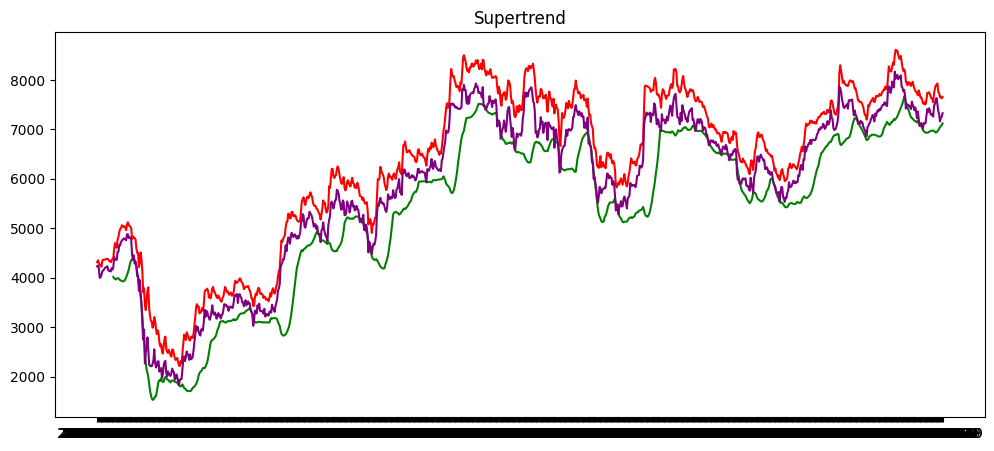

In [39]:
super=SuperTrend(bajaj)
plt.figure(figsize=(12, 5))
plt.plot(super['Date'],super['Lower_Band'],label='Lower_Band',color='green')
plt.plot(super['Date'],super['Upper_Band'],label='Upper_Band',color='red')
plt.plot(super['Date'],super['Close'],label='Close',color='purple')
plt.title('Supertrend')
plt.show()